In [33]:
### Create a function that get data from api

import requests
import pandas as pd

ticker = 'PETR4.SA.SAO'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey=8JDWE75B6RS73XYH&outputsize=full'
data = requests.get(url).json()

time_series = data['Time Series (Daily)']
meta_data = data['Meta Data']

data, open_price, high, low, close, volume, stock, date_refreshed = [], [], [], [], [], [], [], []

for date in time_series.keys():
    data.append(date)
    open_price.append(time_series[date]['1. open'])
    high.append(time_series[date]['2. high'])
    low.append(time_series[date]['3. low'])
    close.append(time_series[date]['4. close'])
    volume.append(time_series[date]['5. volume'])
    stock.append(meta_data['2. Symbol'][:5])
    date_refreshed.append(meta_data['3. Last Refreshed'])

df = pd.DataFrame(data={'date': data, 
                        'open': open_price,
                        'high': high,
                        'low': low,
                        'close': close, 
                        'volume': volume, 
                        'stock': stock, 
                        'date_refreshed': date_refreshed})

In [35]:
df.to_csv('data_petra4_full_20241706.csv', index=False)

In [1]:

import pandas as pd

df = pd.read_csv('data_petra4_full_20241706.csv')

In [2]:
import warnings

warnings.filterwarnings('ignore')


df['dif'] = df['close'].diff()

df = df.sort_values(by='date', ascending=False).head(720)

df.sort_values(by='date', ascending=True, inplace=True)
for column in ['open', 'high', 'low', 'close', 'volume']:
    df[column] = df[column].apply(float)

# Assuming you have a DataFrame named df

for column in ['open', 'high', 'low', 'close', 'volume', 'dif']:
    for day in [3, 7, 15, 30]:
        # Calculate moving average
        df[f'{column}_avg_{day}'] = df[column].rolling(window=day).mean()
        
        # Calculate maximum from previous row
        df[f'{column}_max_{day}'] = df['close'].rolling(window=day).max().shift()

        # Calculate minimum from previous row
        df[f'{column}_min_{day}'] = df['close'].rolling(window=day).min().shift()

        # Calculate standard deviation from previous row
        df[f'{column}_std_{day}'] = df['close'].rolling(window=day).std().shift()
        
        # Calculate the value based on the lag
        df[f'{column}_lag_{day}'] = df['close'].shift(day)

In [3]:
import datetime

df['date'] = pd.to_datetime(df['date'])

df['day_of_the_week'] = df['date'].dt.dayofweek

In [4]:
def relevant_variance(value, threshold):
    if value > threshold:
        return 1
    else:
        return 0

df['target'] = df['dif'].apply(lambda x: relevant_variance(x, 0.5))

In [5]:
X = df.drop(columns=['date', 'stock', 'date_refreshed', 'dif', 'target'])
y = df['target']

In [16]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV

def run_lightgbm_model(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the parameter grid for randomized search
    param_grid = {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, 20],
    }
    
    # Create the LightGBM classifier
    lgb_model = lgb.LGBMClassifier()
    
    # Perform randomized search for best parameters
    randomized_search = RandomizedSearchCV(lgb_model, param_grid, n_iter=10, scoring='roc_auc', cv=3, random_state=42, verbose=1)
    randomized_search.fit(X_train, y_train)
    
    # Get the best parameters and score
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    
    # Train the model with the best parameters
    lgb_model = lgb.LGBMClassifier(**best_params)
    lgb_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = lgb_model.predict(X_test)
        
    return lgb_model, best_params, best_score, y_pred, y_test

In [17]:
lgbm, best_params, best_score, y_pred, y_test = run_lightgbm_model(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 64, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14033
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [18]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[116   0]
 [ 27   1]]


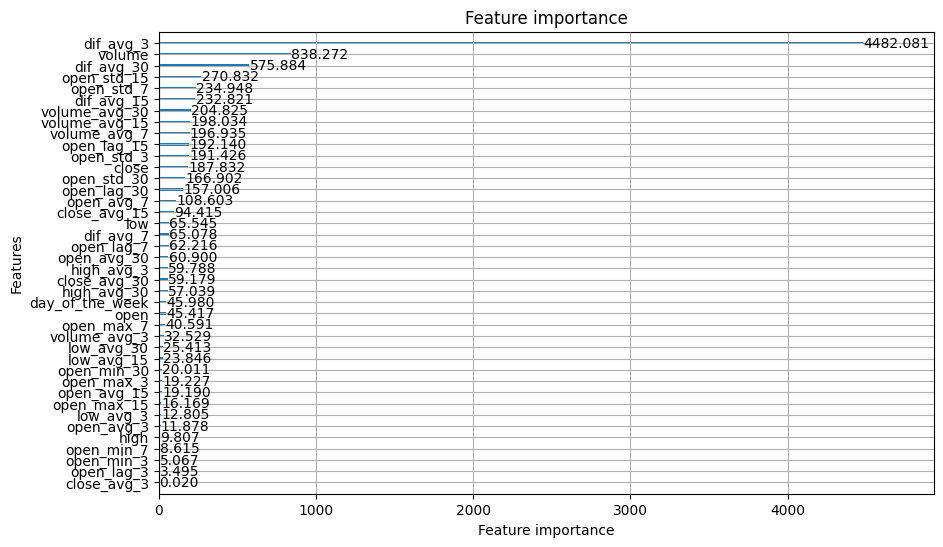

In [20]:
import lightgbm as lgb

import matplotlib.pyplot as plt

# Assuming you have a trained LightGBM model named 'lgbm'
lgb.plot_importance(lgbm, importance_type='gain', figsize=(10, 6))
plt.show()

In [41]:
from scipy.stats import percentileofscore

# Value to find percentile for
value = 0.5

# Calculate the percentile
percentile = percentileofscore(df['dif'], value)

print(f"The value {value} represents the {percentile}% percentile in the series.")

The value 0.5 represents the 83.767576509512% percentile in the series.
